# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [1]:
%matplotlib inline
import edward as ed
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils.setup import set_random_seeds
import data
# set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

Use the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers. For the time being, we are only interested in trips that occurr entirely within the range from 1st street to 59th street, and 12th ave to 1st ave, during the month of april. This data can be easily visualized as 2d plot.

In [ ]:
SELECT
  *
FROM
  [bigquery-public-data:new_york.tlc_yellow_trips_2016]
WHERE
  (pickup_longitude > -74.0124053955
    AND pickup_longitude < -73.9673309326)
  AND (pickup_latitude > 40.7186431885
    AND pickup_latitude < 40.7735137939)
  AND (dropoff_longitude > -74.0124053955
    AND dropoff_longitude < -73.9673309326)
  AND (dropoff_latitude > 40.7186431885
    AND dropoff_latitude < 40.7735137939)
  AND TIMESTAMP_TO_MSEC(pickup_datetime) > 1459483200000
  AND TIMESTAMP_TO_MSEC(dropoff_datetime) < 1462075200000
  order by pickup_datetime desc
LIMIT
  10000

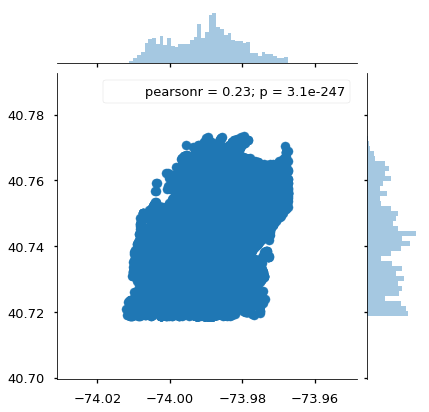

In [18]:
dataset = data.get_data('datasets/results-20171101-101319.csv', name="raw_coordinates")
with tf.Session() as sess:
    rotated_data = sess.run(data.rotate(dataset, np.pi * 0.0))
sns.jointplot(x=rotated_data[0, :], y=rotated_data[1, :])

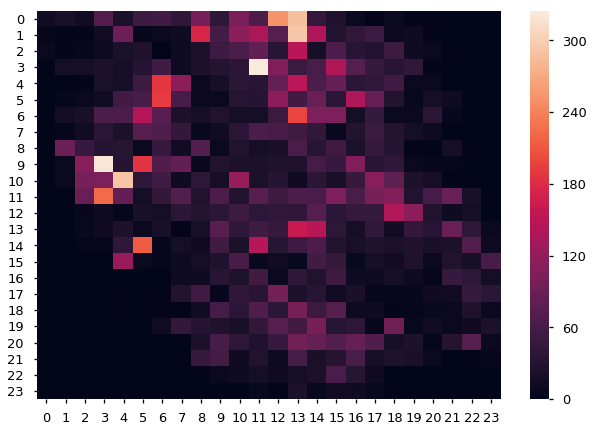

In [37]:


start_longitude = np.min(rotated_data[0, :])
stop_longitude = np.max(rotated_data[0, :])
start_latitude = np.min(rotated_data[1, :])
stop_latitude = np.max(rotated_data[1, :])

n_steps = 25

step_size_longitude = (stop_longitude - start_longitude) / n_steps
step_size_latitude = (stop_latitude - start_latitude) / n_steps

xedges = np.arange(start_longitude, stop_longitude, step_size_longitude)
yedges = np.arange(start_latitude, stop_latitude, step_size_latitude)
H, xedges, yedges = np.histogram2d(rotated_data[0, :], rotated_data[1, :], bins=(xedges, yedges))
H = H.T
sns.heatmap(H)

From this visualization, it looks as though the density of 

## Model

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [5]:
qf = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

Run variational inference for `500` iterations.

In [6]:
inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 82.755


In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)